In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

---- Simulation parameters ----
Generations:    100
Iterations:     20
Total iters:    2000
Signal power:   1.00 dB
Sig cent. freq: -100000.0 Hz
Noise power:    18.00 dB
Noise uncert:   1.00 dB
SNR:            -17.00 dB
Signal length:  0.010000 s
Signal samples: 10000
---- Simulation stats theory ----
Prob false alarm: 0.1000
Prob detection:   nan
Threshold:        1.1332
---- Running simulation ----
Using 8 processes on 8 cores


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


---- Simulation stats ----
Prob false alarm theory: 0.1000
Prob false alarm sim:    0.1018
Prob detection theory:   nan
Prob detection sim:      0.9924


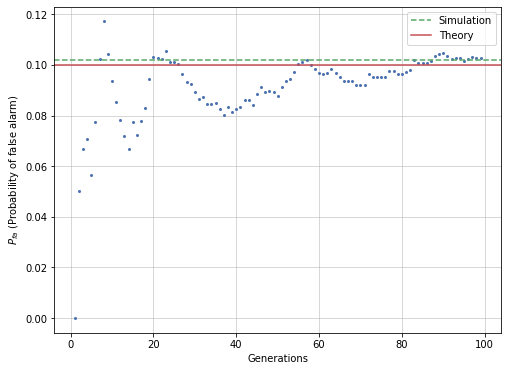

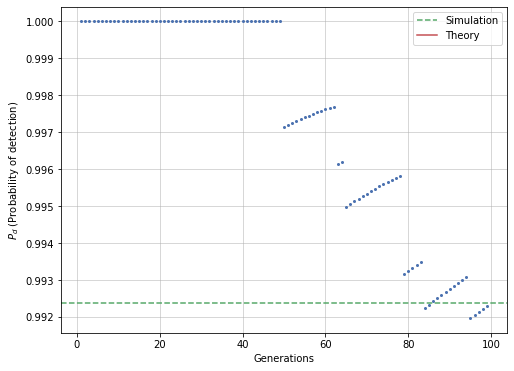

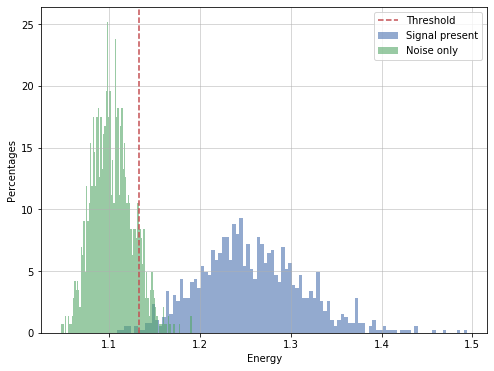

---- Distribution stats ----
Sig present mean: 1.2563
Sig absent  mean: 1.1036
Sig present var:  0.0034
Sig absent  var:  0.0005
Sig present std:  0.0582
Sig absent  std:  0.0222


In [2]:
# eigenvalue detector simulation using mme

_ = ss.eigenvalue_sim(
    gens=100,  # generations, number of environments
    itrs=20,  # iterations, number of tests in each environment
    f_sample=1e6,  # in Hz
    signal_power=1.0,  # in dB
    noise_power=18.0,  # in dB
    length_sec=0.01,  # length of each sample in seconds
    theo_pfa=0.1,  # probability of false alarm
    noise_uncert=1.0,  # standard deviation of the noise normal distribution
    num_procs=None,  # number of processes to run in parallel
    seed=None,  # set seed for reproducibility
    cov_size=10,  # covariance matrix size
    sampling_factor=0.977)